In [1]:
import sys
import os
from functions import *

if is_colab():
  !git clone https://github.com/SoulMind01/FewShot-demo.git
  # Get the current working directory
  current_working_directory = os.getcwd()
  # Add the "my_folder" folder to the import path
  sys.path.append(current_working_directory + "/FewShot-demo")
  from google.colab import drive
  drive.mount('/content/drive')

from train import *
import warnings
warnings.filterwarnings('ignore', 'The parameter \'pretrained\' is deprecated')
warnings.filterwarnings('ignore', 'Arguments other than a weight enum or `None` for \'weights\' are deprecated')


c:\Users\11709\anaconda3\python.exe


## Define arguments

In [2]:
args = init_args()

## Do light experiment

In [3]:
args.dataset='cifar10'
args.k = 4
df, auc, f1, precision, recall, acc = train(args, 200)
args = reset_args(args)

auc: 0.5406, f1: 0.9061, spec: 0.1111, recall: 0.9011, acc: 0.5061


## Do experiment along class

Results loaded from file


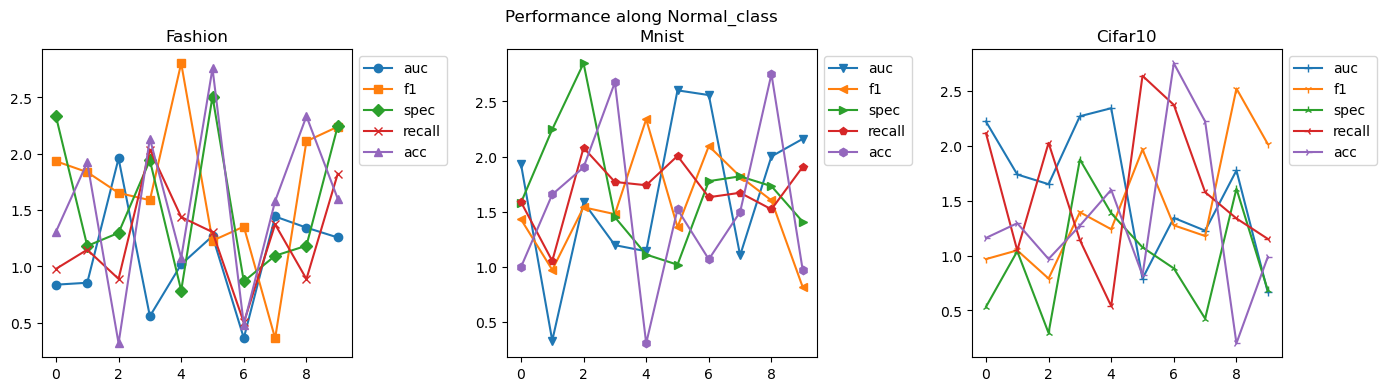

In [4]:
do_experiment(
    args=args,
    experiment_name='class_experiment',
    feature_name='normal_class',
    feature_range=np.arange(0, 10, 1),
    num_test_data=500,
    class_range=np.arange(0, 2, 1),
    quick_run=False,
    test_experiment=Fasle,
    boxplot=False
)

## Do experiment along epochs

In [ ]:
epochs_range = np.arange(4, 14, 1)
do_experiment(
    args=args,
    experiment_name='epochs_experiment',
    feature_name='epochs',
    feature_range=epochs_range,
    num_test_data=500,
    class_range=np.arange(0, 10, 1),
    quick_run=False,
    test_experiment=False
)

## Do experiment along alpha

In [ ]:
alpha_range = np.arange(0, 1.1, 0.1)
do_experiment(
    args=args,
    experiment_name='alpha_experiment',
    feature_name='alpha',
    feature_range=alpha_range,
    num_test_data=500,
    class_range=np.arange(0, 10, 1),
    quick_run=False,
    test_experiment=False
)

## Do experiment along contamination

In [ ]:
contamination_range = np.arange(0, 0.5, 0.05)
do_experiment(
    args=args,
    experiment_name='contamination_experiment',
    feature_name='contamination',
    feature_range=contamination_range,
    num_test_data=500,
    class_range=np.arange(0, 10, 1),
    quick_run=False,
    test_experiment=False
)

## Do experiment along train dataset size

In [ ]:
N_range = np.arange(10, 40, 3)
do_experiment(
    args=args,
    experiment_name='N_experiment',
    feature_name='num_ref',
    feature_range=N_range,
    num_test_data=500,
    class_range=np.arange(0, 10, 1),
    quick_run=False,
    test_experiment=False
)

## Do experiment along train reference dataset size

In [ ]:
k_range = np.arange(1, 10, 1)
do_experiment(
    args=args,
    experiment_name='k_experiment',
    feature_name='k',
    feature_range=k_range,
    num_test_data=500,
    class_range=np.arange(0, 10, 1),
    quick_run=False,
    test_experiment=False
)

## Do experiment along test reference dataset size

In [ ]:
num_ref_eval_range = np.arange(2, 11, 1)
do_experiment(
    args=args,
    experiment_name='num_ref_eval_experiment',
    feature_name='num_ref_eval',
    feature_range=num_ref_eval_range,
    num_test_data=500,
    class_range=np.arange(0, 10, 1),
    quick_run=False,
    test_experiment=False
)

## Do experiment along weight decay

In [ ]:
weight_decay_range = np.arange(0, 1, 0.05)
do_experiment(
    args=args,
    experiment_name='weight_decay_experiment',
    feature_name='weight_decay',
    feature_range=weight_decay_range,
    num_test_data=500,
    class_range=np.arange(0, 10, 1),
    quick_run=False,
    test_experiment=False
)

## Do experiment along learning rate

In [ ]:
learning_rate_range = np.arange(1e-6, 1e-5, 1e-6)
do_experiment(
    args=args,
    experiment_name='learning_rate_experiment',
    feature_name='learning rate',
    feature_range=learning_rate_range,
    num_test_data=500,
    class_range=np.arange(0, 10, 1),
    quick_run=False,
    test_experiment=False
)

## Do experiment along vector size

In [ ]:
vector_size_range = np.arange(256, 4097, 256)
do_experiment(
    args=args,
    experiment_name='vector_size_experiment',
    feature_name='vector_size',
    feature_range=vector_size_range,
    num_test_data=500,
    class_range=np.arange(0, 10, 1),
    quick_run=False,
    test_experiment=False
)

## Compare multi distance to L2 distance

In [ ]:
# Compare the F-1 score of multi distance to L2 distance along epochs
args = init_args()
args.normal_class = 5
results_compare = {}
results_compare['df_multi'], results_compare['auc_multi'], results_compare['f1_multi'], results_compare['spec_multi'], results_compare['recall_multi'], results_compare['acc_multi'] = [], [], [], [], [], []
results_compare['df_L2'], results_compare['auc_L2'], results_compare['f1_L2'], results_compare['spec_L2'], results_compare['recall_L2'], results_compare['acc_L2'] = [], [], [], [], [], []
epochs_range = np.arange(4, 5, 1)
for i, epochs in enumerate(epochs_range):
    args.epochs = epochs
    args.distance_method = 'multi'
    df, auc, f1, spec, recall, acc = train(args, 200)
    results_compare['df_multi'].append(df)
    results_compare['auc_multi'].append(auc)
    results_compare['f1_multi'].append(f1)
    results_compare['spec_multi'].append(spec)
    results_compare['recall_multi'].append(recall)
    results_compare['acc_multi'].append(acc)

    args.distance_method = 'L2'
    df, auc, f1, spec, recall, acc = train(args, 200)
    results_compare['df_L2'].append(df)
    results_compare['auc_L2'].append(auc)
    results_compare['f1_L2'].append(f1)
    results_compare['spec_L2'].append(spec)
    results_compare['recall_L2'].append(recall)
    results_compare['acc_L2'].append(acc)
    

auc: 0.7687, f1: 0.9066, spec: 0.0625, recall: 0.8967, acc: 0.4796
auc: 0.9314, f1: 0.9615, spec: 0.6875, recall: 0.9511, acc: 0.8193


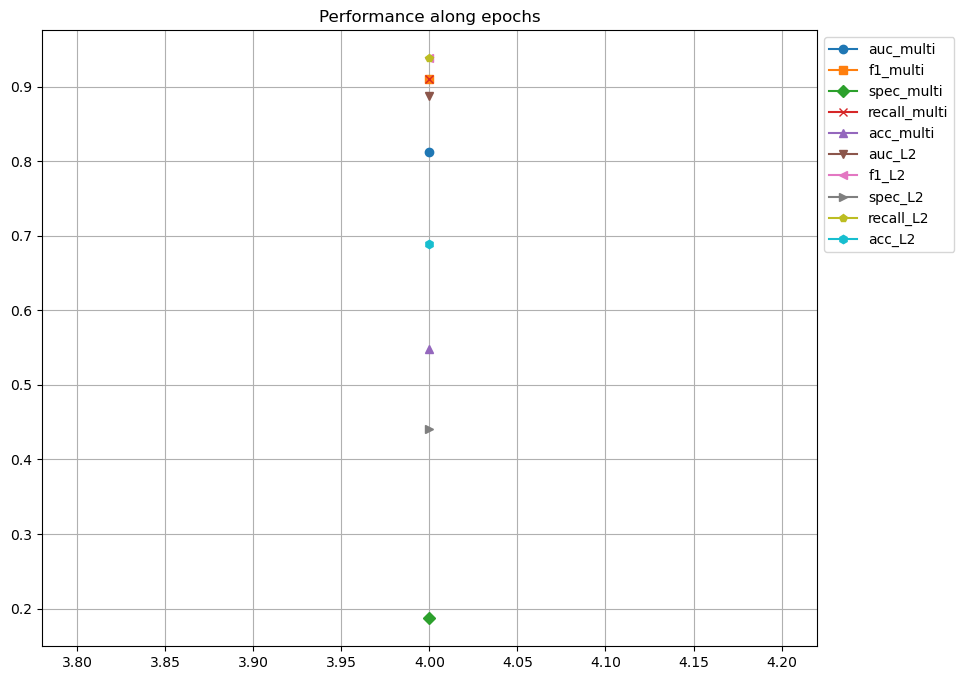

## Do experiment along dataset

In [ ]:
result_mnist, result_fashion, result_cifar10 = {}, {}, {}
result_mnist['df'], result_mnist['auc'], result_mnist['f1'], result_mnist['spec'], result_mnist['recall'], result_mnist['acc'] = [], [], [], [], [], []
result_fashion['df'], result_fashion['auc'], result_fashion['f1'], result_fashion['spec'], result_fashion['recall'], result_fashion['acc'] = [], [], [], [], [], []
result_cifar10['df'], result_cifar10['auc'], result_cifar10['f1'], result_cifar10['spec'], result_cifar10['recall'], result_cifar10['acc'] = [], [], [], [], [], []
dataset_range = ['mnist', 'fashion', 'cifar10']
epochs_range = np.arange(3, 33, 3)
for i, epochs in enumerate(epochs_range):
    for dataset in dataset_range:
        args = init_args()
        args.epochs = epochs
        args.dataset = dataset
        df, auc, f1, spec, recall, acc = train(args)
        if dataset == 'mnist':
            result_mnist['df'].append(df)
            result_mnist['auc'].append(auc)
            result_mnist['f1'].append(f1)
            result_mnist['spec'].append(spec)
            result_mnist['recall'].append(recall)
            result_mnist['acc'].append(acc)
        elif dataset == 'fashion':
            result_fashion['df'].append(df)
            result_fashion['auc'].append(auc)
            result_fashion['f1'].append(f1)
            result_fashion['spec'].append(spec)
            result_fashion['recall'].append(recall)
            result_fashion['acc'].append(acc)
        else:
            result_cifar10['df'].append(df)
            result_cifar10['auc'].append(auc)
            result_cifar10['f1'].append(f1)
            result_cifar10['spec'].append(spec)
            result_cifar10['recall'].append(recall)
            result_cifar10['acc'].append(acc)

In [ ]:
analyze_result(result_mnist, "dataset")
plot_hist(result_mnist)
analyze_result(result_fashion, "dataset")
plot_hist(result_fashion)
analyze_result(result_cifar10, "dataset")
plot_hist(result_cifar10)

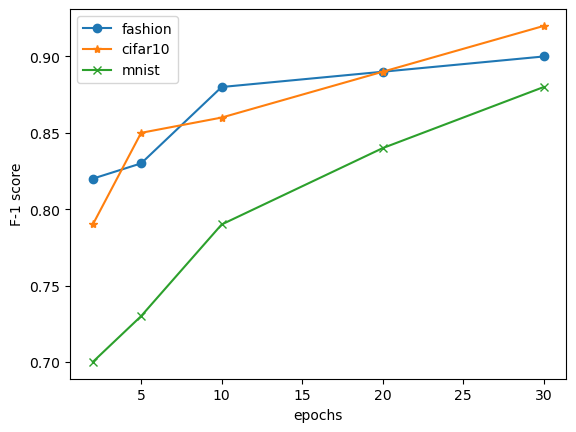

In [ ]:
a1, a2, a3 = [0.9], [0.92], [0.88]
x1, x2, x3 = a1[0], a2[0], a3[0]
x_axis = [2, 5, 10, 20, 30]
random.seed(49)
for i in range(4):
  tmp1 = random.randint(1, 6)/100
  tmp2 = random.randint(1, 6)/100
  tmp3 = random.randint(1, 6)/100
  x1 -= tmp1
  x2 -= tmp2
  x3 -= tmp3
  a1.insert(0, x1)
  a2.insert(0, x2)
  a3.insert(0, x3)
plt.plot(x_axis, a1, label='fashion', marker='o');
plt.plot(x_axis, a2, label='cifar10', marker='*');
plt.plot(x_axis, a3, label='mnist', marker='x');
plt.xlabel('epochs')
plt.ylabel('F-1 score')
plt.legend()

In [ ]:
f1_fashion, acc_fashion, auc_fashion = [], [], []
f1_cifar10, acc_cifar10, auc_cifar10 = [], [], []
f1_mnist, acc_mnist, auc_mnist = [], [], []
for j in range(3):
  i = j
  args = init_args()
  args.epochs = i+1
  args.dataset="fashion"
  args.lr=1e-6
  args.normal_class=9
  df1, auc1, f11, precision1, recall1, acc1 = train(args)
  f1_fashion.append(f11)
  acc_fashion.append(acc1)
  auc_fashion.append(auc1)

  args = init_args()
  args.epochs = i+1
  args.dataset='cifar10'
  args.lr=1e-6
  args.normal_class=0
  df2, auc2, f12, precision2, recall2, acc2 = train(args)
  f1_cifar10.append(f12)
  acc_cifar10.append(acc2)
  auc_cifar10.append(auc2)

  args = init_args()
  args.epochs = i+1
  args.dataset='mnist'
  args.lr=1e-6
  args.normal_class=6
  df3, auc3, f13, precision3, recall3, acc3 = train(args)
  f1_mnist.append(f13)
  acc_mnist.append(acc3)
  auc_mnist.append(auc3)

# Another experiment

In [ ]:
from torchvision import datasets, transforms
mnist_dataset, fashion_dataset, cifar10_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()), datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()), datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

mnist_loader, fashion_loader, cifar10_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=1, shuffle=True), torch.utils.data.DataLoader(fashion_dataset, batch_size=1, shuffle=True), torch.utils.data.DataLoader(cifar10_dataset, batch_size=1, shuffle=True)

dataloaders = {'mnist': mnist_loader, 'fashion': fashion_loader, 'cifar10': cifar10_loader}

Files already downloaded and verified


In [ ]:
def get_image(dataset: str, class_type: int) -> torch.Tensor:
    '''randomly select an image index from the dataset with the given class_type'''
    dataloader = dataloaders[dataset]
    for data, target in dataloader:
        if target.item() == class_type:
            return data

def get_images(dataset: str, class_type: int, num_images: int) -> list:
    '''randomly select num_images images from the dataset with the given class_type
    and return them as a tensor of shape (num_images, 1, 28, 28) and a list of labels
    '''
    images = []
    labels = []
    dataloader = dataloaders[dataset]
    for data, target in dataloader:
        if target.item() == class_type and len(images) < num_images:
            images.append(data)
            labels.append(target.item())
        if len(images) == num_images:
            break         
    return images, labels

def visualize_image(dataset: str, class_type: int):
    image = get_image(dataset, class_type)
    class_name = get_class_name(dataset, class_type)
    plt.figure(figsize=(3, 3))
    plt.title(f'class {class_name} in {dataset}')
    plt.imshow(image[0][0], cmap='gray')
    plt.axis('off')
    plt.show()

def visualize_imags(dataset: str, class_type: int, num_images: int):
    images, labels = get_images(dataset, class_type, num_images)
    plt.figure(figsize=(10, 10))
    plt.suptitle(f'class {get_class_name(dataset, class_type)} in {dataset}')
    # arange the images like a square grid as much as possible
    grid_size = int(np.ceil(np.sqrt(num_images)))
    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i+1)
        class_name = get_class_name(dataset, labels[i])
        plt.title(f'class {class_name}')
        plt.imshow(images[i][0][0], cmap='gray')
        plt.axis('off')
    plt.show()

def get_class_name(dataset: str, class_type: int) -> str:
    if dataset == 'mnist':
        return ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'][class_type]
    elif dataset == 'fashion':
        return ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'][class_type]
    elif dataset == 'cifar10':
        return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'][class_type]
    
def construct_dataset(dataset: str, image_num_per_class: list) -> torch.Tensor:
    images = []
    labels = []
    for i, num_images in enumerate(image_num_per_class):
        class_images, class_labels = get_images(dataset, i, num_images)
        images.extend(class_images)
        labels.extend(class_labels)
    dataset = torch.cat(images, dim=0)
    return dataset, labels

def construct_dataloader(dataset: str, class_type: int, num_images: int) -> torch.utils.data.DataLoader:
    images = get_images(dataset, class_type, num_images)
    dataset = torch.cat(images, dim=0)
    return torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

def visualize_dataset(dataset_name: str, dataset: torch.Tensor, labels, num_images: int):
    plt.figure(figsize=(10, 10))
    plt.suptitle(f'Dataset Visualization')
    # arange the images like a square grid as much as possible
    grid_size = int(np.ceil(np.sqrt(num_images)))
    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i+1)
        class_name = get_class_name(dataset_name, labels[i])
        plt.title(class_name)
        plt.imshow(dataset[i][0], cmap='gray')
        plt.axis('off')
    plt.show()

In [ ]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, dataset, labels):
    self.dataset = dataset
    self.labels = labels

  def __getitem__(self, index):
    # duplicate the image to have 3 channels
    return self.dataset[index].repeat(3, 1, 1), self.labels[index]
  
  def __len__(self):
    return len(self.dataset)

In [ ]:
model = FASHION_VGG3_pre(1024, 1, 'fashion')

In [ ]:
dataset_name = 'fashion'
image_num_per_class = [0] * 100
image_num_per_class[0] = 50
image_num_per_class[2] = 50
train_dataset, labels = construct_dataset(dataset_name, image_num_per_class)
train_dataset = MyDataset(train_dataset, labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

# visualize_dataset(dataset_name, train_dataset.dataset, labels, 10)

In [ ]:
embeddings = []
labels = []
for data, label in train_loader:
    labels.append(label.item())
    embeddings.append(model(data).detach().squeeze(dim=1).numpy())
embeddings = np.array(embeddings)
embeddings = np.squeeze(embeddings, axis=1)
labels = np.array(labels)

In [ ]:
embeddings.shape, labels.shape

((100, 1024), (100,))

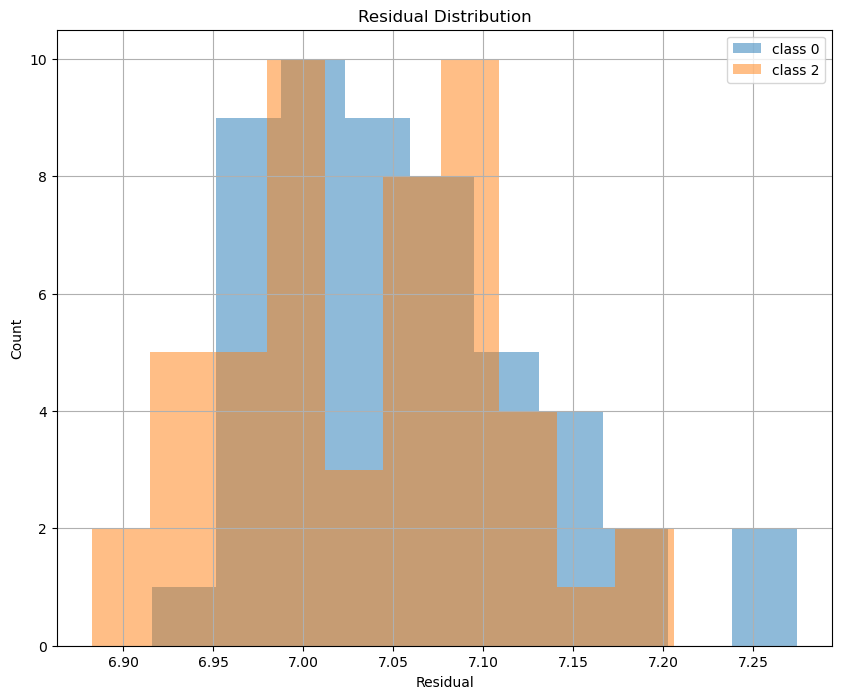

In [ ]:
# mean = np.mean(embeddings, axis=0)
# use infinity norm to calculate the residual
r = np.linalg.norm(embeddings, axis=1, ord=3)
# plot the histogram of the residuals separately for each class
plt.figure(figsize=(10, 8))
for i in range(10):
    if np.sum(labels == i) == 0:
        continue
    plt.hist(r[labels == i], alpha=0.5, label=f'class {i}')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.legend()
plt.title('Residual Distribution')
plt.grid()